<a href="https://colab.research.google.com/github/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/blob/main/EDA_Medical_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Problem**

Medical imaging is the process of creating visual representations of the interior of a body for clinical analysis as well as visual representation of the function of some organs or tissues.
They are widely used in hospitals and clinics to determine fractures and diseases. The medical images are read and interpreted by specialized medical professionals and their findings regarding each body of area examined are communicated via written Medical Reports. The process of writing medical reports usually takes around 5-10 minutes per report. In a day the doctors have to write medical reports that number in 100s which can take a lot of their time. The objective of this case study is to build a deep learning model that automatically write the impression part of medical report of chest X-rays and alleviate some of the burden of the medical professional. Here I will be taking a publicly available dataset from Indiana University which consists of chest X-ray images and reports (in XML format) which contain information regarding the findings and impression of the X-ray. The goal is to predict the impressions of the medical report attached to the images.

# **Metric Used**

Here we will be using [BLEU](https://towardsdatascience.com/bleu-bilingual-evaluation-understudy-2b4eab9bcfd1) score as  the metric. BLEU score compares each word in the predicted sentence and compare it to the reference sentence (It is also done in n-grams) and returns score based on how many words were predicted that were in the original sentence. BLEU score is not a good metric to compare the performance of translation since simililar words that have the same meaning will be penalized. So we will not only use n-gram BLEU score but also take a sample of the predicted captions and compare it to the original reference caption manually. 

# **Dataset Used**
Here I will be taking a publicly available dataset from Indiana University which consists of chest X-ray [images](https://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d) and [reports](https://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9) (in XML format) which contain information regarding the findings and impression of the X-ray. The goal is to predict the impressions of the medical report attached to the images.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud

# **Exploratory Data Analysis**

## **Images**

In [ ]:
image_folder = '/content/drive/My Drive/Medical image Reporting/Images' #path to folder containing images
total_images = len(os.listdir(image_folder))
print('The number of images in data are: %i'%(total_images))

The number of images in data are: 7471


1)



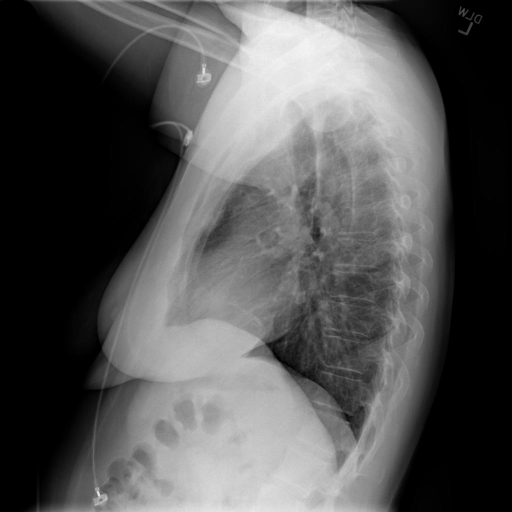

		 CXR1294_IM-0193-2001.png
2)



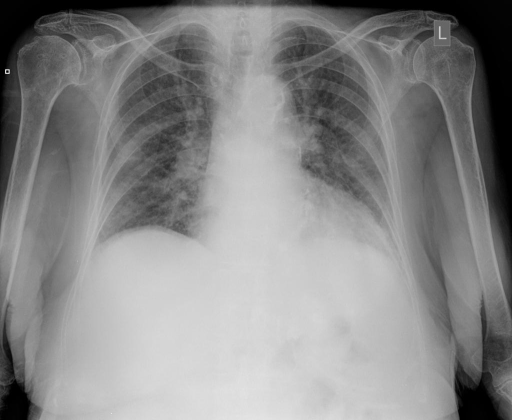

		 CXR2688_IM-1159-4004.png
3)



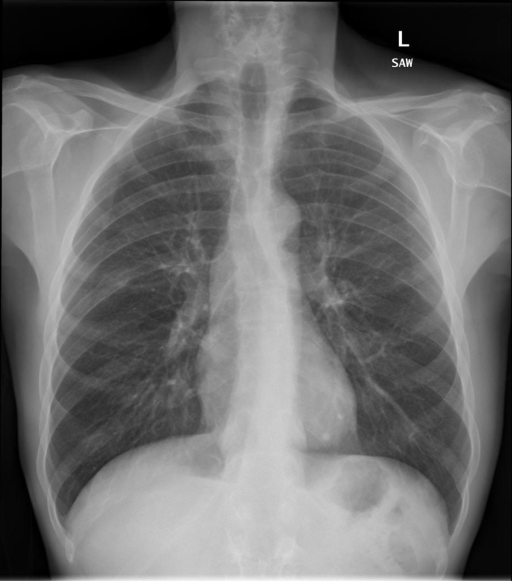

		 CXR3657_IM-1818-1001.png
4)



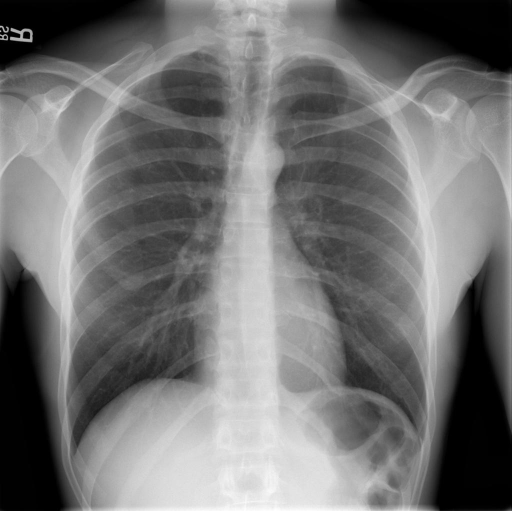

		 CXR429_IM-2070-1001.png
5)



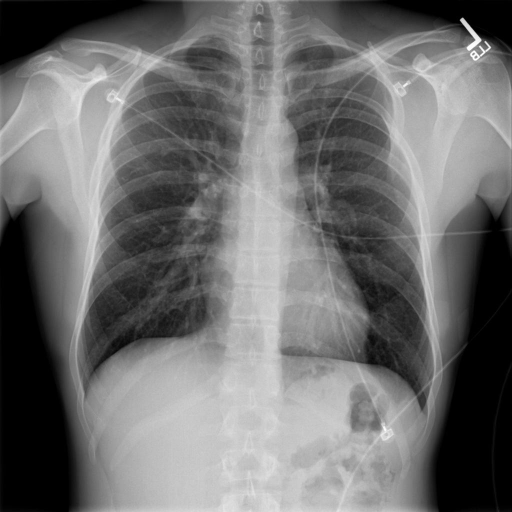

		 CXR3713_IM-1855-1001.png


In [ ]:
#showing random 5 sample images
np.random.seed(420)
for i in range(5): #print 5 sample images
  k = np.random.choice(range(total_images))
  image_file = os.listdir(image_folder)[k]
  image = cv2.imread(os.path.join(image_folder,image_file)) #getting an image file
  print("%i)\n"%(i+1))
  cv2_imshow(image)
  print("\t\t",image_file) #the image file name

We can see 5 sample images of the dataset. These are chest X_rays which are taken in  front and side view.

## **Reports**

In [ ]:
reports_folder = "/content/drive/My Drive/Medical image Reporting/Reports/ecgen-radiology"
total_reports = len(os.listdir(reports_folder))
print('The number of reports in the data are: %i'%(total_reports))

The number of reports in the data are: 3955


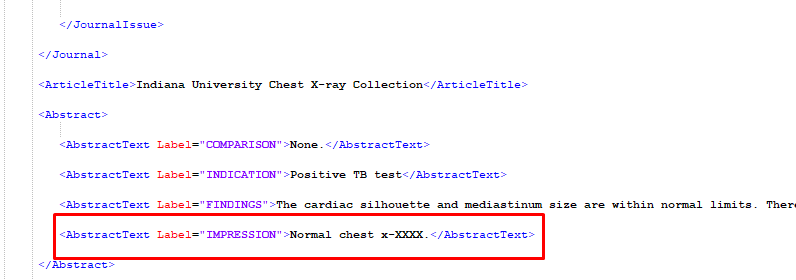

This is the impression part of the X-ray report that is stored in xml file that we will extract.

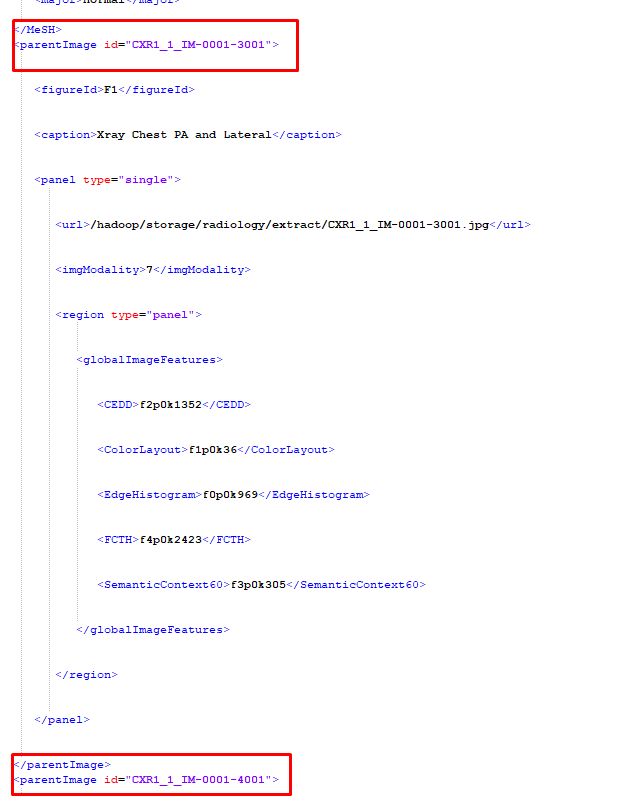

These are the two image files that are associated with the report.

We will extract the impression part of the report and the corresponding 2 images of the concerned report to a dataframe with xml report file name. We will be not considering those reports which does not have 2 images and also those reports which does not have any impression part.

In [ ]:
# function for obtaining the impression part of the xml report file and preprocessing them and also adding the concernced image and impression to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


def get_impression(xml_data): #https://regex101.com/
  """
  extracts the impression data form the xml file and does text preprocessing on them
  """
  regex = r"\"IMPRESSION\".*" 
  k = re.findall(regex,xml_data)[0] #finding impression part of the report

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing '"IMPRESSION"' and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for comma and full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  return k

def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding impression text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  caption = [] #stores captions
  report = [] #stores xml file name
  for file in os.listdir(reports_folder):
    report_file = os.path.join(reports_folder,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
  
    regex = r"parentImage id.*" #getting all the image names
    k  = re.findall(regex,data)

    if len(k)==2: #only considering those xml pages with 2 images
      regex = r"\".*\"" #getting the name
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]

      regex = r"\"" #removing "
      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)

      try: #some reports are having no impression ignoring those
        impression = get_impression(data)
      except:
        continue;
      report.append(file)
      im1.append(image1.strip()+".png")
      im2.append(image2.strip()+".png")
      caption.append(impression) 

  df = pd.DataFrame({"image_1":im1,"image_2":im2,"impression":caption,"xml file name":report})
  return df

In [ ]:
%%time
df = get_df()

CPU times: user 1.59 s, sys: 771 ms, total: 2.36 s
Wall time: 26min 20s


In [ ]:
# df.to_pickle("/content/drive/My Drive/Medical image Reporting/df.pkl")
df = pd.read_pickle("/content/drive/My Drive/Medical image Reporting/df.pkl")
df.shape

(3189, 4)

We can see that the final dataframe has a total of 3189 datapoints. Around 700 (around 1200 images) reports either had no impression part or only contained one image. Now we can look at some of the datapoints.

In [ ]:
df.head()

,image_1,image_2,impression,xml file name
0,CXR601_IM-2192-1001.png,CXR601_IM-2192-1002.png,bilateral lower lung airspace disease right gr...,601.xml
1,CXR600_IM-2192-1001.png,CXR600_IM-2192-2001.png,negative for acute abnormality .,600.xml
2,CXR605_IM-2194-1001.png,CXR605_IM-2194-1002.png,small nodular opacity in left upper lung may b...,605.xml
3,CXR59_IM-2184-1001.png,CXR59_IM-2184-2001.png,no acute abnormalities are seen .,59.xml
4,CXR594_IM-2187-1001.png,CXR594_IM-2187-2001.png,borderline cardiomegaly . age indeterminate ch...,594.xml


### **Wordcloud of Impressions**

In [ ]:
#getting wordclouds
#https://www.geeksforgeeks.org/generating-word-cloud-python/
temp = df.loc[:,'impression'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable
words = ""
for i in temp.values:
  k = i.split()
  words+= " ".join(k) + " "
word = words.strip()
wc = WordCloud(width = 1024, height = 720, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 15,).generate(words) 

del k,words,temp

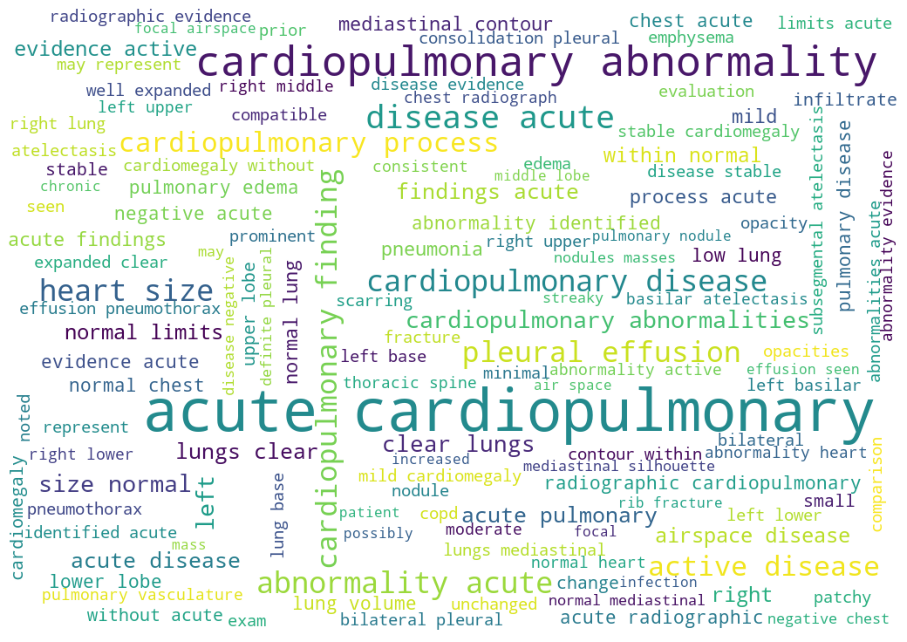

In [ ]:
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.axis("off")
plt.show()

## **Sample Images + Caption**

In [ ]:
def show_image_captions(im1,im2,caption,image_folder = image_folder):
  """
  given the name of the two images and captions prints them in a nice and tidy fashion
  im1: image 1 name
  im2: image 2 name
  caption : caption
  image_folder: folder which contains images
  """
  image = [] # stores the images
  for i in [im1,im2]:
    image.append(cv2.imread(os.path.join(image_folder,i)))
  plt.figure(figsize = (12,8)) #setting the figure size

  plt.subplot(121) #first x-ray
  plt.imshow(image[0],aspect='auto')

  plt.subplot(122) #2nd x-ray
  plt.imshow(image[1], aspect = 'auto')

  plt.show() #printing the image
  print("\n","Impression: ",caption,"\n\n")

1)




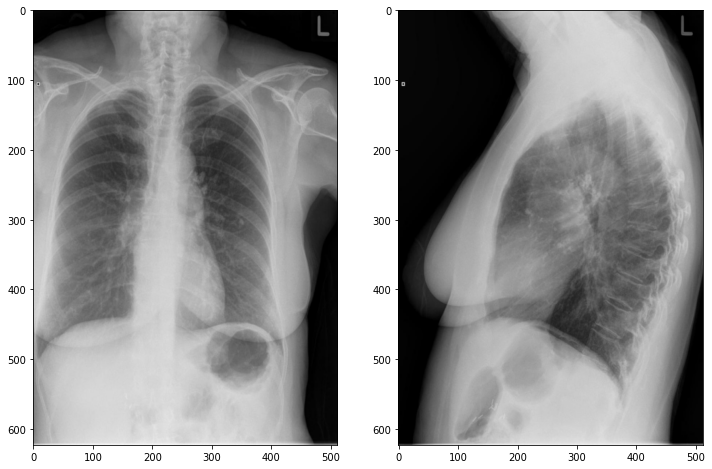


 Impression:  hyperexpanded lung compatible with copd . no evidence of acute cardiopulmonary abnormality . 


2)




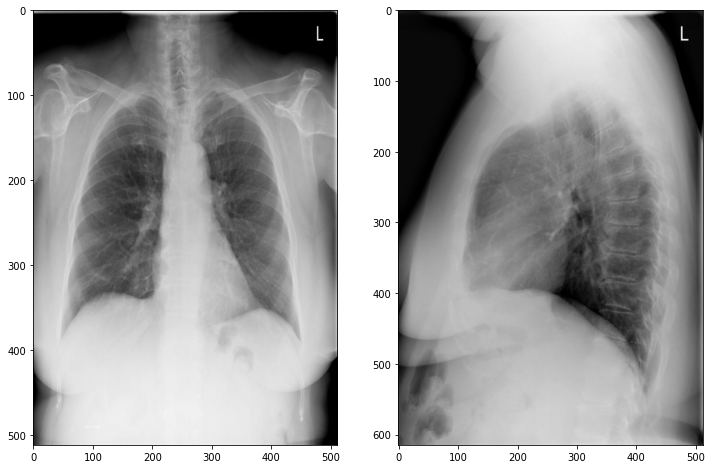


 Impression:  no acute disease . 


3)




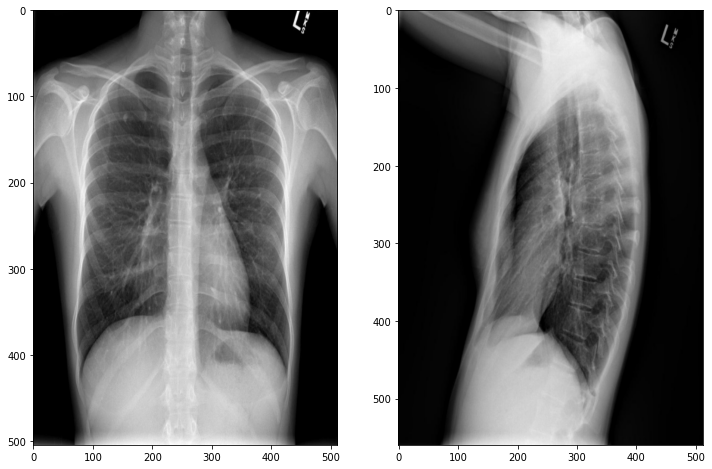


 Impression:  no acute cardiopulmonary process . 


4)




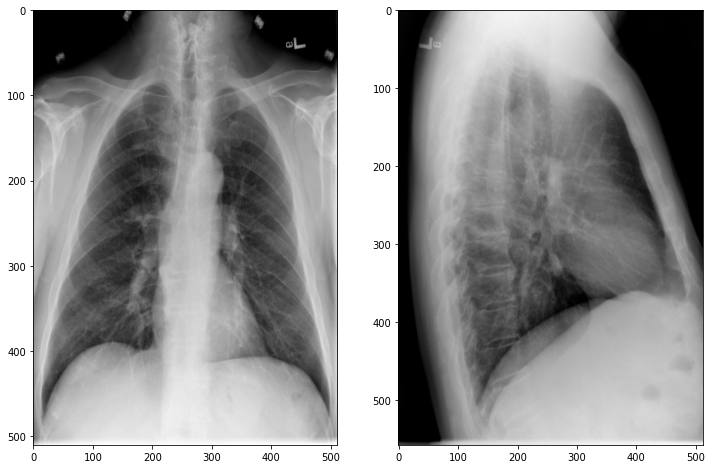


 Impression:  no acute process . 


5)




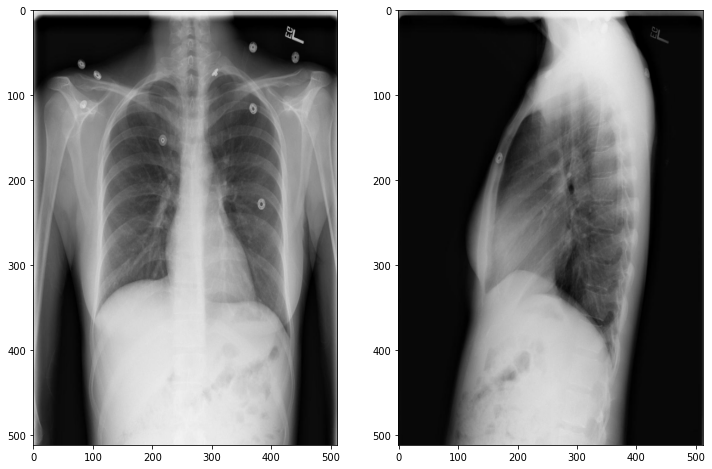


 Impression:  no evidence of active disease . 




In [ ]:
#showing sample 5 datapoints
for i in range(5):
  series = df.sample(1).iloc[0,:] #gets the only row in sampled df
  print(str(i+1)+")\n\n")
  show_image_captions(series.iloc[0],series.iloc[1],series.iloc[2])